In [27]:
import torch
from torch.autograd import Variable
import numpy as np
import torch.functional as F
import torch.nn.functional as F

In [28]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import wordnet
nltk.download('stopwords')
from nltk.corpus import stopwords
STOPWORDS = stopwords.words('english')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\batur\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\batur\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\batur\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\batur\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [31]:
import re, string 
import pandas as pd   
from collections import defaultdict
import spacy
from sklearn.manifold import TSNE

from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
%matplotlib inline
#Tokenizer
df = pd.read_csv('bbc_data.csv')
df.columns= ['news_article'] 
def clean_text(text):
    #Make text lowercase, remove square brackets, remove punctuation and remove words containing numbers.
    text = text.lower()
    text = re.sub(r'[\[\]\(\)\{\}]', '', text)
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub(r'\w*\d\w*', '', text)
    
    text = word_tokenize(text)
    # Remove a sentence if it is only one word long
    if len(text) > 2:
        return [word for word in text if word not in STOPWORDS]

tokenized_corpus = df['news_article'].apply(lambda x: clean_text(x))
print(tokenized_corpus[0:10])

0    [claxton, hunting, first, major, medal, britis...
1    [osullivan, could, run, worlds, sonia, osulliv...
2    [greene, sets, sights, world, title, maurice, ...
3    [iaaf, launches, fight, drugs, iaaf, athletics...
4    [dibaba, breaks, world, record, ethiopias, tir...
5    [isinbayeva, claims, new, world, best, pole, v...
6    [osullivan, commits, dublin, race, sonia, osul...
7    [hansen, delays, return, british, triple, jump...
8    [offcolour, gardener, storms, win, britains, j...
9    [collins, compete, birmingham, world, commonwe...
Name: news_article, dtype: object


In [32]:
print(tokenized_corpus[0])
print(type(tokenized_corpus[0][0]))

['claxton', 'hunting', 'first', 'major', 'medal', 'british', 'hurdler', 'sarah', 'claxton', 'confident', 'win', 'first', 'major', 'medal', 'next', 'months', 'european', 'indoor', 'championships', 'madrid', 'already', 'smashed', 'british', 'record', 'hurdles', 'twice', 'season', 'setting', 'new', 'mark', 'seconds', 'win', 'aaas', 'title', 'quite', 'confident', 'said', 'claxton', 'take', 'race', 'comes', 'long', 'keep', 'training', 'much', 'think', 'chance', 'medal', 'claxton', 'national', 'hurdles', 'title', 'past', 'three', 'years', 'struggled', 'translate', 'domestic', 'success', 'international', 'stage', 'scotlandborn', 'athlete', 'owns', 'equal', 'fifthfastest', 'time', 'world', 'year', 'last', 'weeks', 'birmingham', 'grand', 'prix', 'claxton', 'left', 'european', 'medal', 'favourite', 'russian', 'irina', 'shevchenko', 'trailing', 'sixth', 'spot', 'first', 'time', 'claxton', 'preparing', 'campaign', 'hurdles', 'could', 'explain', 'leap', 'form', 'previous', 'seasons', 'also', 'conte

In [33]:
#Applying tokenizer
df_clean = pd.DataFrame(tokenized_corpus)
df_clean.head(5)

,news_article
0,"[claxton, hunting, first, major, medal, britis..."
1,"[osullivan, could, run, worlds, sonia, osulliv..."
2,"[greene, sets, sights, world, title, maurice, ..."
3,"[iaaf, launches, fight, drugs, iaaf, athletics..."
4,"[dibaba, breaks, world, record, ethiopias, tir..."


In [34]:
nlp = spacy.load("en_core_web_sm")
df_clean = pd.DataFrame(tokenized_corpus)
def lemmatizer(text):        
    sent = []
    doc = nlp(" ".join(text))
    for word in doc:
        sent.append(word.lemma_)
    return sent

df_clean["text_lemmatize"] =  df_clean.apply(lambda x: lemmatizer(x['news_article']), axis=1)

In [35]:
df_clean.head(5)

,news_article,text_lemmatize
0,"[claxton, hunting, first, major, medal, britis...","[claxton, hunt, first, major, medal, british, ..."
1,"[osullivan, could, run, worlds, sonia, osulliv...","[osullivan, could, run, world, sonia, osulliva..."
2,"[greene, sets, sights, world, title, maurice, ...","[greene, set, sight, world, title, maurice, gr..."
3,"[iaaf, launches, fight, drugs, iaaf, athletics...","[iaaf, launch, fight, drug, iaaf, athletic, wo..."
4,"[dibaba, breaks, world, record, ethiopias, tir...","[dibaba, break, world, record, ethiopia, tirun..."


In [38]:
sentences = [row for row in df_clean['text_lemmatize']]
word_freq = defaultdict(int)
for sent in sentences:
    for i in sent:
        word_freq[i] += 1
        
sorted(word_freq, key=word_freq.get, reverse=True)[:10]

['say',
 '-PRON-',
 'mr',
 'year',
 'would',
 'make',
 'also',
 'people',
 'new',
 'one']

In [46]:
#Traing Word2Vec model, words with frequency less than 100 are removed from vocabulary, window is maximum distance to
#context, size - feature vector size
import sys
w2v_model = Word2Vec(min_count=100,
                     window=5,
                     size=100,
                     workers=4)
                     
w2v_model.build_vocab(sentences)
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=w2v_model.iter)
w2v_model.init_sims(replace=True)

D:\anaconda\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
  


In [70]:
# 10 most simular words to america
w2v_model.wv.most_similar(positive=['america'])

[('uks', 0.9818187355995178),
 ('investor', 0.9654662013053894),
 ('indian', 0.9466589689254761),
 ('stock', 0.9459162950515747),
 ('post', 0.9421418905258179),
 ('sign', 0.9415537118911743),
 ('decline', 0.9402013421058655),
 ('north', 0.9389501214027405),
 ('german', 0.9369186162948608),
 ('china', 0.936127245426178)]

In [69]:
#most simular words to america+endgland-money
w2v_model.wv.most_similar(positive=['america','england'], negative=['money'])

[('champion', 0.9451249241828918),
 ('february', 0.9378058314323425),
 ('saturday', 0.9252316355705261),
 ('france', 0.9216691255569458),
 ('tour', 0.9189246892929077),
 ('olympic', 0.9128143787384033),
 ('festival', 0.9119681119918823),
 ('west', 0.9087016582489014),
 ('cup', 0.9064081907272339),
 ('defeat', 0.9062701463699341)]

In [71]:
#most simular words to america+england
w2v_model.wv.most_similar(positive=['america','england'])

[('australia', 0.9779956936836243),
 ('spain', 0.9635127782821655),
 ('west', 0.9561886191368103),
 ('de', 0.9543925523757935),
 ('french', 0.9515681266784668),
 ('begin', 0.9513149261474609),
 ('italy', 0.9509208798408508),
 ('australian', 0.9472274780273438),
 ('death', 0.946779727935791),
 ('june', 0.9446929693222046)]

In [72]:
#most simular words to america-money
w2v_model.wv.most_similar(positive=['america'], negative=['money'])

[('south', 0.8971230983734131),
 ('london', 0.883212685585022),
 ('york', 0.8363950848579407),
 ('chart', 0.8350083231925964),
 ('africa', 0.8297613859176636),
 ('follow', 0.8294092416763306),
 ('v', 0.8254475593566895),
 ('february', 0.8141018152236938),
 ('november', 0.8104081749916077),
 ('tuesday', 0.8074185848236084)]

In [78]:
#What closer to america, true if russia, false if china
w2v_model.wv.distance("america", "russia")>w2v_model.wv.distance("america", "china")

True

D:\anaconda\lib\site-packages\ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # This is added back by InteractiveShellApp.init_path()


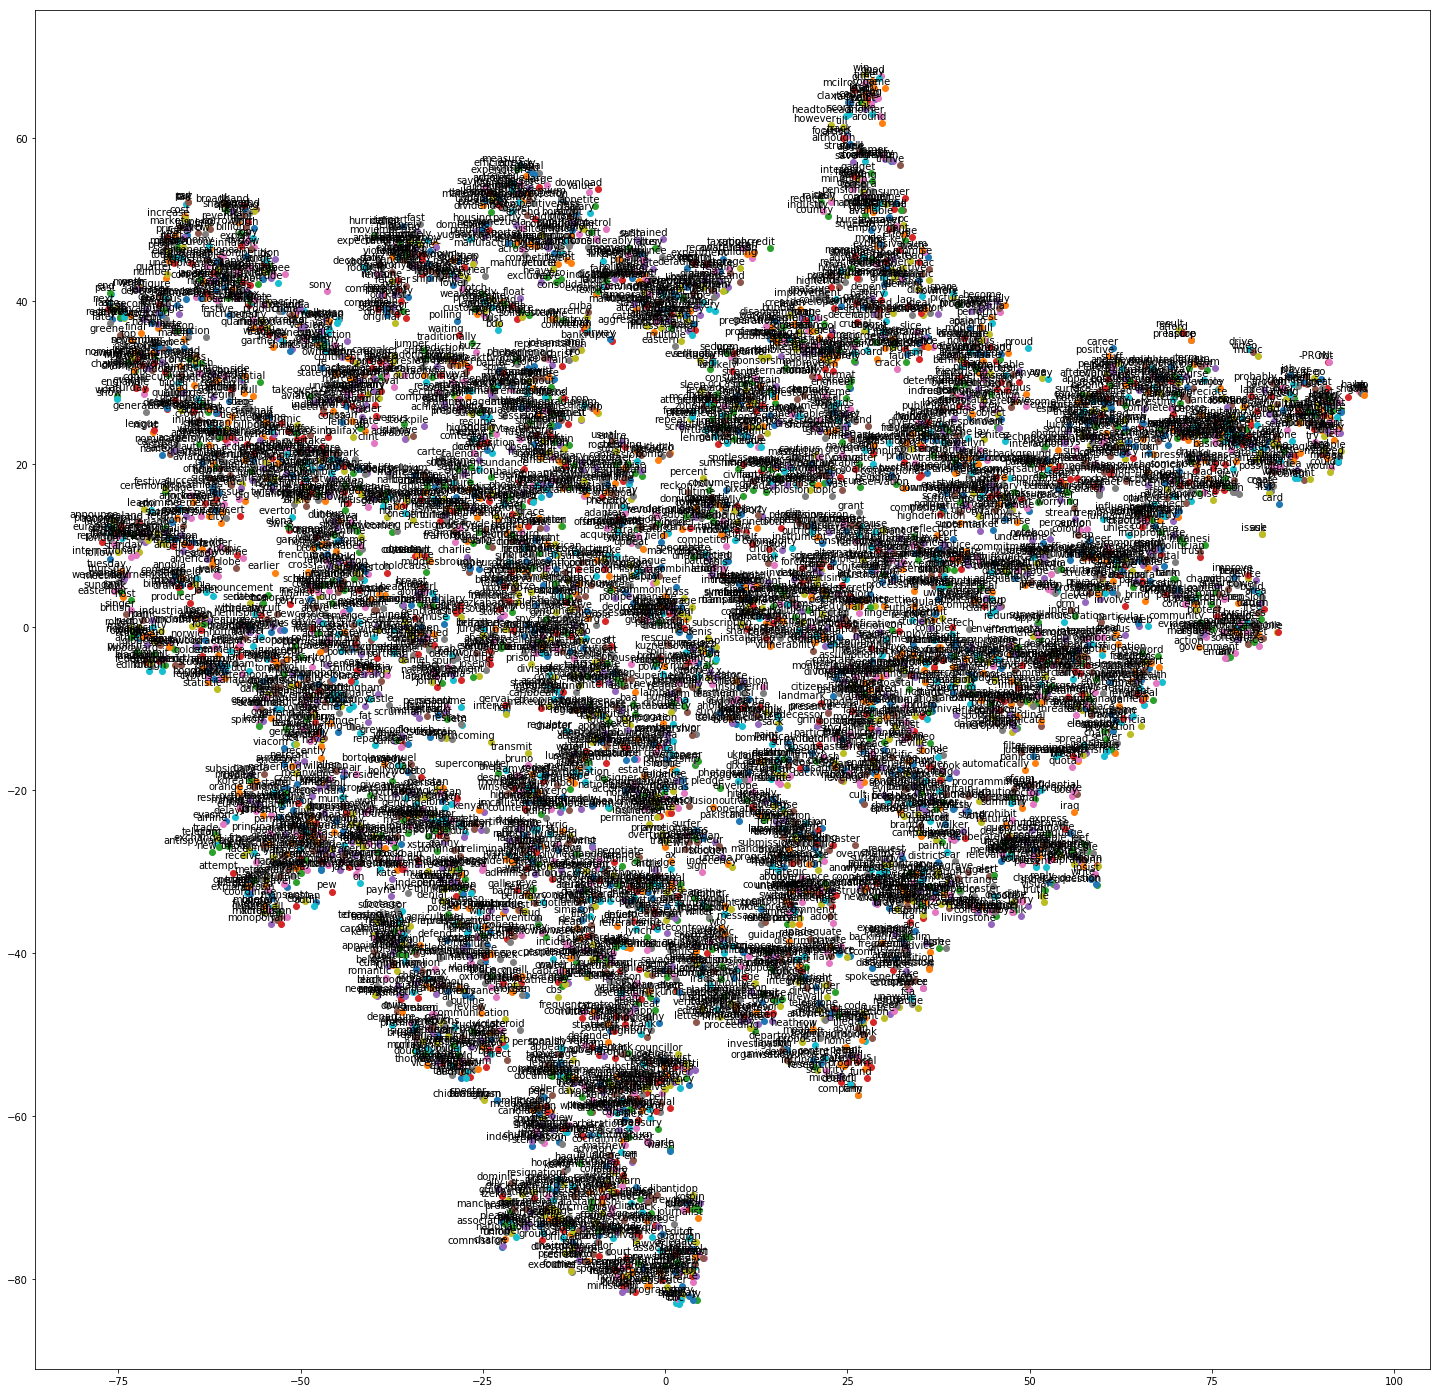

In [20]:
#Cloud of dots
import matplotlib.pyplot as plt

%matplotlib inline

def tsne_plot(model):
    "Create TSNE model and plot it"
    labels = []
    tokens = []

    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)
   
    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
    # print(x, y)        
    plt.figure(figsize=(25,25)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()
    
tsne_plot(w2v_model)